In [27]:
import simpy
import random
import seaborn as sns
import pandas as pd
from common import tiempo_aleatorio_operador, aleatorio_exponencial


In [28]:
def get_tiempo(evento):
    return evento.estado.tiempo


def inserta_evento(evento, lista_eventos):
    lista_eventos.append(evento)
    lista_eventos.sort(key=get_tiempo)
    
    return lista_eventos


def nuevo_cliente(estado, evento_actual, eventos_futuros):
    
    estado.tiempo = evento_actual.estado.tiempo
    tiempo_atencion = 0

    agregar_cola = True
    active_op = False
    
    for operador in estado.operadores:
        if (operador.estado == 0) and (active_op == False):
            agregar_cola = False
            active_op = True
            operador.estado = 1

            tiempo_atencion = tiempo_aleatorio_operador(operador.tiempo_prob)
            tiempo_fin =  tiempo_atencion + evento_actual.estado.tiempo

            nuevo_estado = Estado(tiempo_fin, estado.operadores, estado.cola, tiempo_atencion, operador)

            nuevo_evento = Evento('final_cliente', nuevo_estado)

            eventos_futuros = inserta_evento(nuevo_evento, eventos_futuros)


    if agregar_cola:
        estado.cola += 1
        
        
    return eventos_futuros, estado

def final_cliente(estado, evento_actual, eventos_futuros):
    estado.tiempo = evento_actual.estado.tiempo
    
    if(estado.cola > 0):
        # Si hay cola se saca a uno de la cola
        estado.cola -= 1
        
        active_op = False
        for operador in estado.operadores:
            if (operador.estado == 0) and (active_op == False):
                active_op = True
                tiempo_atencion = tiempo_aleatorio_operador(operador.tiempo_prob)
                tiempo_fin = tiempo_atencion + estado.tiempo
                nuevo_estado = Estado(tiempo_fin, estado.operadores, estado.cola, tiempo_atencion, operador)
        
                nuevo_evento = Evento('final_cliente', nuevo_estado)
                eventos_futuros = inserta_evento(nuevo_evento, eventos_futuros)

            
            
    else:
        # Si no hay cola
        for operador in estado.operadores:
            operador.estado = 0

        
    return eventos_futuros, estado

## Declaracion de Objetos

### Objeto Operador

In [29]:
class Operador(object):
    def __init__(self, nombre, tiempo_prob, estado):
        self.nombre = nombre
        self.tiempo_prob = tiempo_prob
        self.estado = estado
        
    

### Objeto Evento

In [30]:
class Evento(object):
    def __init__(self, tipo, estado):
        self.tipo = tipo
        self.estado = estado
        

### Objeto Estado

In [31]:
class Estado(object):
    def __init__(self, tiempo, operadores, cola, tiempo_atencion=0, operador=None):
        self.tiempo = tiempo
        self.operadores = operadores
        self.cola = cola
        self.tiempo_atencion = tiempo_atencion
        self.operador = operador

# Operador A

In [32]:
dict_probabilidades = {
    (0,0.3):2,
    (0.3,0.5):2.5,
    (0.5,0.75):3,
    (0.75,1):4
}

operador_a = Operador('operador_a', dict_probabilidades, 0)

# Operador B

In [33]:
## Operador 1
dict_probabilidades = {
    (0,0.15): 2,
    (0.15,0.3): 2.5,
    (0.3,0.7): 3,
    (0.7,0.9): 3.5,
    (0.9, 1): 4
}

operador_b = Operador('operador_b', dict_probabilidades, 0)

## Eventos

Tipos de evento:
- inicio
- nuevo_cliente
- final_cliente

# Simulacion

In [34]:
lista_eventos = []
lista_eventos_futuros = []

### Evento Inicial

In [35]:
# Tiempo = 0
# Estado operador = 0
# Cola = 0
estado_inicial = Estado(0, [operador_a, operador_b],0)

evento_inicial = Evento('inicio', estado_inicial)

In [36]:
lista_eventos_futuros.append(evento_inicial)

### Agregando Clientes

In [37]:
tiempo_clientes = 0
TOTAL_CLIENTES = 100

for i in range(TOTAL_CLIENTES):
    tiempo_clientes += aleatorio_exponencial(1/7)
    evento = Evento('nuevo_cliente', Estado(tiempo_clientes, 0,0))
    lista_eventos_futuros.append(evento)
    

In [38]:
estado_actual = Estado(0,[operador_a, operador_b],0)
cliente_actual = 0

while (len(lista_eventos_futuros) > 0):
    
    #Obtenemos el siguiente evento futuro
    evento_actual = lista_eventos_futuros.pop(0)
    

    if evento_actual.tipo == 'nuevo_cliente':
        lista_eventos_futuros, estado_actual = nuevo_cliente(
            estado_actual,
            evento_actual,
            lista_eventos_futuros
        )
       
     
    if evento_actual.tipo == 'final_cliente':
        lista_eventos_futuros, estado_actual = final_cliente(
            estado_actual,
            evento_actual,
            lista_eventos_futuros
        )
        
        cliente_actual += 1
    
    
    nuevo_estado = Estado(
        estado_actual.tiempo,
        estado_actual.operadores,
        estado_actual.cola,
        evento_actual.estado.tiempo_atencion,
        evento_actual.estado.operador
    )
    
    nuevo_evento = Evento(evento_actual.tipo, nuevo_estado)
    lista_eventos.append(nuevo_evento)
    

## Resultados

### Objeto cliente

In [39]:
class Cliente(object):
    def __init__(self, id_cliente, tiempo_llegada, tiempo_salida, cola, tiempo_atencion, operador):
        self.id_cliente = id_cliente
        self.tiempo_llegada = tiempo_llegada
        self.tiempo_salida = tiempo_salida
        self.cola = cola
        self.tiempo_atencion = tiempo_atencion
        self.operador = operador
        

In [49]:
lista_clientes = []

In [50]:
id_cliente = 1
current_client = 0

for evento in lista_eventos:

    if evento.tipo == 'nuevo_cliente':
        cliente_nuevo = Cliente(id_cliente, evento.estado.tiempo, 0, 
                                evento.estado.cola, 0, evento.estado.operador)
        id_cliente += 1
        lista_clientes.append(cliente_nuevo)
            
    if evento.tipo == 'final_cliente':
        lista_clientes[current_client].tiempo_atencion = evento.estado.tiempo_atencion
        lista_clientes[current_client].tiempo_salida = evento.estado.tiempo
        lista_clientes[current_client].operador = evento.estado.operador

        
        current_client +=1

In [51]:
clientes_dict = {
    'cliente': [],
    'tiempo_llegada': [],
    'tiempo_salida': [],
    'operador': [],
    'cola': [],
    'tiempo_atencion': [],
    'tiempo_cola' : []
}

In [52]:
for cliente in lista_clientes:
    # print(f"===== Cliente {cliente.id_cliente}")
    # print(f"Llegada {cliente.id_cliente}")
    # print(f"tiempo_llegada: {cliente.tiempo_llegada}")
    # print(f"tiempo_salida: {cliente.tiempo_salida}")
    # print(f"cola: {cliente.cola}")
    # print(f"tiempo_atencion: {cliente.tiempo_atencion}")
    
    clientes_dict['cliente'].append(f"Cliente {cliente.id_cliente}")
    clientes_dict['tiempo_llegada'].append(cliente.tiempo_llegada)
    clientes_dict['tiempo_salida'].append(cliente.tiempo_salida)
    
    try:
        clientes_dict['operador'].append(cliente.operador.nombre)
    except:
        clientes_dict['operador'].append("")
        
    clientes_dict['cola'].append(cliente.cola)
    clientes_dict['tiempo_atencion'].append(cliente.tiempo_atencion)
    
    tiempo_cola = 0
    if cliente.cola > 0:
        tiempo_cola = cliente.tiempo_salida - cliente.tiempo_atencion - cliente.tiempo_llegada
    
    clientes_dict['tiempo_cola'].append(tiempo_cola)

In [53]:
df_clientes = pd.DataFrame(clientes_dict)

In [54]:
df_clientes['tiempo_sistema'] = df_clientes.tiempo_salida - df_clientes.tiempo_llegada

In [55]:
df_clientes

,cliente,tiempo_llegada,tiempo_salida,operador,cola,tiempo_atencion,tiempo_cola,tiempo_sistema
0,Cliente 1,0.696966,2.696966,operador_a,0,2.0,0.000000,2.000000
1,Cliente 2,1.965523,4.465523,operador_b,0,2.5,0.000000,2.500000
2,Cliente 3,2.061161,10.022786,operador_a,1,2.0,5.961625,7.961625
3,Cliente 4,8.022786,25.215290,operador_a,0,3.0,0.000000,17.192503
4,Cliente 5,22.215290,32.930450,operador_a,0,2.0,0.000000,10.715160
...,...,...,...,...,...,...,...,...
95,Cliente 96,652.013038,690.525097,operador_a,0,2.5,0.000000,38.512060
96,Cliente 97,671.753757,694.292234,operador_a,0,3.0,0.000000,22.538478
97,Cliente 98,688.025097,694.406699,operador_b,0,2.0,0.000000,6.381601
98,Cliente 99,691.292234,0.000000,,0,0.0,0.000000,-691.292234


In [56]:
df_clientes = df_clientes[df_clientes.operador != ""]

# Estadisticas

In [57]:
clientes_cola = df_clientes[df_clientes.cola >=0]

In [58]:
clientes_cola

,cliente,tiempo_llegada,tiempo_salida,operador,cola,tiempo_atencion,tiempo_cola,tiempo_sistema
0,Cliente 1,0.696966,2.696966,operador_a,0,2.0,0.000000,2.000000
1,Cliente 2,1.965523,4.465523,operador_b,0,2.5,0.000000,2.500000
2,Cliente 3,2.061161,10.022786,operador_a,1,2.0,5.961625,7.961625
3,Cliente 4,8.022786,25.215290,operador_a,0,3.0,0.000000,17.192503
4,Cliente 5,22.215290,32.930450,operador_a,0,2.0,0.000000,10.715160
...,...,...,...,...,...,...,...,...
93,Cliente 94,641.164579,655.013038,operador_b,0,3.0,0.000000,13.848459
94,Cliente 95,651.433343,673.753757,operador_a,0,2.0,0.000000,22.320414
95,Cliente 96,652.013038,690.525097,operador_a,0,2.5,0.000000,38.512060
96,Cliente 97,671.753757,694.292234,operador_a,0,3.0,0.000000,22.538478


## Tiempo medio en Cola 

In [59]:
clientes_cola.tiempo_cola.mean()

0.2757634242567961

/home/erick/anaconda3/envs/geometria_diff/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='tiempo_cola', ylabel='Density'>

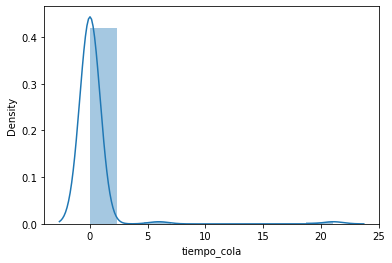

In [60]:
sns.distplot(clientes_cola.tiempo_cola)

## Longitud promedio de Cola

In [61]:
clientes_cola.cola.mean()

0.02040816326530612

## Tiempo medio en el sistema

In [62]:
df_clientes.tiempo_sistema.mean()

13.939662099970935

/home/erick/anaconda3/envs/geometria_diff/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='tiempo_sistema', ylabel='Density'>

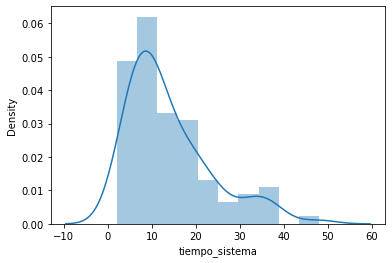

In [63]:
sns.distplot(df_clientes.tiempo_sistema)

## Porcentaje Ocupacion

```
for evento in lista_eventos:
    print(f"=== Evento: {evento.tipo} ===")
    print(f"Cola: {evento.estado.cola}")
    print(f"Estado Operador: {evento.estado.estado_operador}")
    print(f">> Tiempo: {evento.estado.tiempo}")
    
    if evento.tipo == 'final_cliente':
        print(f">> Tiempo Atencion: {evento.estado.tiempo_atencion}")
            
    print()
```